# LSA

© Anatolii Stehnii, 2018

Main goal of this assignment is to give you a basic understanding of how Latent Semantic Analysis is performed and how to interpret it results. In this work you will calculate word embeddings using LSA for arbitrary text and explore their properties.

Code from [Yuri Guts's Thrones2Vec](https://github.com/YuriyGuts/thrones2vec/blob/master/Thrones2Vec.ipynb) is used.

In [1]:
%env LC_ALL=en_US.UTF-8
%env LANG=en_US.UTF-8

import os
import re

import nltk
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

env: LC_ALL=en_US.UTF-8
env: LANG=en_US.UTF-8


## Corpus preprocessing

First, download any text and save it in `./data/part1/corpus.txt`. I recommend you to use English text, but if you feel brave enough, you can setup a pipleline for any other language.

In [14]:
data_dir = "../data/part1"
corpus_file = os.path.join(data_dir, "corpus.txt")

with open(corpus_file, "r", ) as f:
    corpus = f.read()
print("Corpus is {0} characters long.".format(len(corpus)))

Corpus is 9748084 characters long.


We need to split our corpus on documents and split documents on terms. Use English tokenizers from NLTK or create your own function.

In [15]:
nltk.download("punkt")
nltk_english = nltk.data.load('tokenizers/punkt/english.pickle')
# use this or define your own document_tokenize
document_tokenize = lambda corpus: nltk_english.tokenize(corpus)

# use this or define your own word_tokenize
from nltk import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anatolii.stehnii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
# split corpus on documents
documents_raw = document_tokenize(corpus)
# split documents on tokens
documents = list(map(word_tokenize, documents_raw))

In [17]:
documents[1]

['``', 'The', 'wildlings', 'are', 'dead', '.', "''"]

Add your preprocessing if needed or use default:

In [18]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

# default preprocessing – leave only alphabetical characters and stem tokens
# redefine this function, if you need another pipeline
def preprocess(word):
    stem = ps.stem(word)
    clean = re.sub("[^a-zA-Z]","", stem)
    clean_lower = clean.lower()
    return clean_lower

In [19]:
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anatolii.stehnii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# replace each word with preprocessed
documents = [[preprocess(word) for word in document if word.lower() not in stop_words] for document in documents]
# filter empty tokens
documents = [[word for word in document if word] for document in documents]

In [26]:
# Compare raw and preprocessed documents
print("Raw document: {}\n".format(documents_raw[5]))
print("Preprocessed document: {}\n".format(documents[5]))
print("-"*80)
token_count = sum([len(document) for document in documents])
print("The corpus contains {0:,} tokens in {1:,} documents".format(token_count, len(documents)))

Raw document: He was an old man, past fifty, and he had seen the lordlings come and go.

Preprocessed document: ['old', 'man', 'past', 'fifti', 'seen', 'lordl', 'come', 'go']

--------------------------------------------------------------------------------
The corpus contains 912,299 tokens in 158,726 documents


Here we are filtering rare words from our documents. We clearly will not be able to analyze a word, if it occurs only a few times in a text. Define your threshold for a minimum word occurence in the text to filter rare words.

In [27]:
min_word_count = 3

words_count = {}
for d in documents:
    for w in d:
        if w in words_count:
            words_count[w] += 1
        else:
            words_count[w] = 1

rare_words = {w for w, count in words_count.items() if count < min_word_count}
print("The corpus vocabulary contains {0:,} unique words, {1:,} with less than {2:} occurences.".format(len(words_count), len(rare_words), min_word_count))

The corpus vocabulary contains 9,978 unique words, 0 with less than 3 occurences.


Define your own set of stop words or use default from NLTK:

In [28]:
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#stop_words = {'a', 'an', 'the'}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anatolii.stehnii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# remove stop words and rare words from documents
remove_words = rare_words | stop_words
documents = [[word for word in document if word not in remove_words] for document in documents]
print("Filtered document: {}" .format(documents[5]))
print("-"*80)

all_words = {word for document in documents for word in document}
vocabulary = {w:i for i, w in enumerate(sorted(all_words))}
print("A filtered vocabulary contains {} unique words".format(len(vocabulary)))

Filtered document: ['old', 'man', 'past', 'fifti', 'seen', 'lordl', 'come', 'go']
--------------------------------------------------------------------------------
A filtered vocabulary contains 9977 unique words


## Term-document matrix

Here you need to transform your corpus into term-document matrix of any type you want (BoW, TF-IDF). Use a sparse matrix, if you have large amount of data. Don't forget to save your vocabulary so you can restore a row index for each word.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(vocabulary=all_words)
tfidf_docs = [' '.join(d) for d in documents]
tf_idf_matrix = tfidf.fit_transform(tfidf_docs)

In [31]:
tf_idf_matrix

<158726x9977 sparse matrix of type '<class 'numpy.float64'>'
	with 891779 stored elements in Compressed Sparse Row format>

## SVD

Perform SVD of term-document matrix and reduce it's dimensionality to n_dim components. 

In [32]:
n_dim = 20

In [33]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_dim)
u = svd.fit_transform(tf_idf_matrix.T)

In [34]:
word_embeddings = u

## Explore result

Select a set of words you would like to explore.

In [35]:
words = ['king', 'queen', 'robert', 'cersei', 'daeneri', 'man', 'woman']
indexes = [vocabulary[word] for word in words]

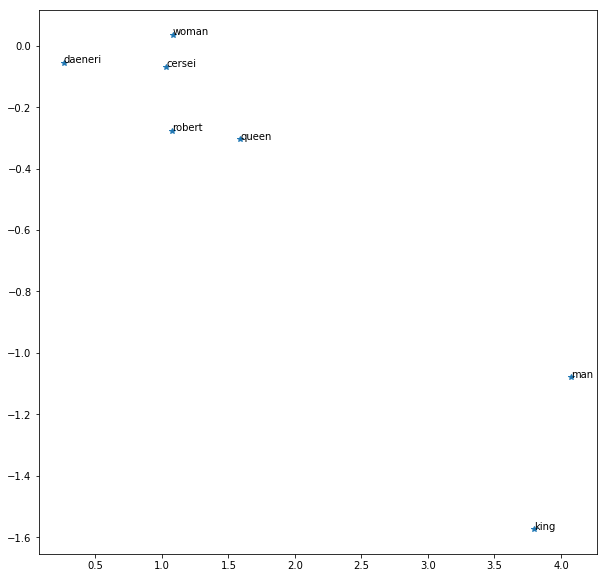

In [36]:
word_vectors = [(word_embeddings[i, 0], word_embeddings[i, 1]) for i in indexes]
xy = list(zip(*word_vectors))
x=xy[0]
y=xy[1]
plt.plot(x, y, '*')

for word, x, y in zip (words, x, y):
    plt.text(x, y, word)

plt.show()

Create a plot with your words, use first two components for x and y.

### Word analogy
1. Measure distances (cosine, euclidean) between test words.
2. Check if distances have meaning.

In [48]:
import itertools
from scipy.spatial.distance import cosine, euclidean

for w1, w2 in itertools.combinations(words, 2):
    v1 = word_embeddings[vocabulary[w1]]
    v2 = word_embeddings[vocabulary[w2]]
    distance = cosine(v1, v2)
    print('Similarity for words {} and {}: {}'.format(w1, w2, distance))

Similarity for words king and queen: 0.38262248782339203
Similarity for words king and robert: 0.20129086518351225
Similarity for words king and cersei: 0.7478332236321272
Similarity for words king and daeneri: 0.8348700272712637
Similarity for words king and man: 1.0328579398014928
Similarity for words king and woman: 0.849243885816946
Similarity for words queen and robert: 0.1990035184797786
Similarity for words queen and cersei: 0.3361404197540756
Similarity for words queen and daeneri: 0.2445403115619068
Similarity for words queen and man: 0.6584062248668459
Similarity for words queen and woman: 0.36560465026464073
Similarity for words robert and cersei: 0.3739849676795839
Similarity for words robert and daeneri: 0.4309901468262006
Similarity for words robert and man: 0.9256020534333234
Similarity for words robert and woman: 0.5142930491432093
Similarity for words cersei and daeneri: 0.16393277399042683
Similarity for words cersei and man: 0.9358999437693635
Similarity for words ce

### Components meaning

Try to find meaning for individual components: select words with the most high values and the most low values for some dimension.

In [41]:
component = 1
values = word_embeddings[:,component].tolist()

word_values = list(sorted(zip(vocabulary.keys(), values), key=lambda x: x[1]))
word_values[:50]

[('would', -7.533187053126823),
 ('know', -6.886688499259003),
 ('lord', -4.728021270568082),
 ('one', -4.564660283657913),
 ('could', -2.677117708172796),
 ('nt', -2.514082559526418),
 ('want', -2.2699717132060635),
 ('say', -1.9102692123559524),
 ('see', -1.8545201668093596),
 ('like', -1.7676718814295944),
 ('king', -1.5739949840394905),
 ('come', -1.5578939658533857),
 ('look', -1.5423676438908254),
 ('well', -1.4567513084253623),
 ('never', -1.3147301524310295),
 ('hand', -1.3087175147022414),
 ('men', -1.237275654788786),
 ('told', -1.2264982024571345),
 ('even', -1.1686564779673148),
 ('back', -1.1483799349946873),
 ('thought', -1.1465955067684148),
 ('ask', -1.1063004572618258),
 ('man', -1.080043062269019),
 ('go', -1.0649178728311939),
 ('father', -0.932498538413195),
 ('eye', -0.9184140837580944),
 ('take', -0.9019151446091814),
 ('us', -0.8945940893264667),
 ('time', -0.8702544054598159),
 ('son', -0.8073788060378302),
 ('day', -0.786350729826035),
 ('way', -0.7839541754850

In [42]:
word_values[-50:]

[('ygritt', 0.05026513092902153),
 ('bronn', 0.05514521923716343),
 ('sorri', 0.05577623875547464),
 ('uncertainli', 0.05697112996984601),
 ('arstan', 0.0576178274899608),
 ('sadli', 0.05908560680459496),
 ('podrick', 0.06023875748571065),
 ('tormund', 0.06220058950603515),
 ('shock', 0.0634293274188511),
 ('tom', 0.06379589938748746),
 ('oh', 0.06484204271663835),
 ('tone', 0.06682320558307783),
 ('loudli', 0.06694442004113364),
 ('angrili', 0.06698887730115809),
 ('gerri', 0.06989208619671157),
 ('bluntli', 0.07240590659027135),
 ('khaleesi', 0.0795237899752583),
 ('pyp', 0.07968689976851136),
 ('scorn', 0.08129975750611045),
 ('barristan', 0.08252685734205803),
 ('lem', 0.08549839274009191),
 ('quietli', 0.09240388823637476),
 ('luwin', 0.0927418500524789),
 ('haldon', 0.09337491309048697),
 ('vari', 0.09800510450071473),
 ('maester', 0.10122690318484907),
 ('stubbornli', 0.10340720263448336),
 ('grenn', 0.10677166595484901),
 ('brienn', 0.11028996700840257),
 ('robb', 0.13590159295

## Save results
We will need preprocessed dataset and word embeddings in the next assignment, so let's save it.

In [43]:
# Store vocabulary as word per line. Indexes can be easily restored from order, therore they are ommited
with open(os.path.join(data_dir, 'vocabulary.txt'), "w") as f:
    vocab_str = '\n'.join(vocabulary.keys())
    f.write(vocab_str)

In [44]:
# Store corpus, document per line, each token replaced with index
with open(os.path.join(data_dir, 'corpus_preprocessed.txt'), "w") as f:
    corpus_str = '\n'.join([' '.join([str(vocabulary[token]) for token in document]) for document in documents])
    f.write(corpus_str)

In [45]:
# Store LSA embeddings
np.save(os.path.join(data_dir, 'lsa_embeddings.npy'), word_embeddings)